In [8]:
import matplotlib as mpl
import numpy as np
import pandas as pd

import scipy as sp
import datetime
import talib
import matplotlib.pylab as plt
import os


import seaborn as sbn
from scipy.stats import norm
from scipy.stats import lognorm
import statsmodels.api as sm
import statsmodels.formula.api as smf


from datetime import datetime
from dateutil import relativedelta
from scipy.stats import norm


# Below is the code for Black-Scholes Merton model for valuation of Options:

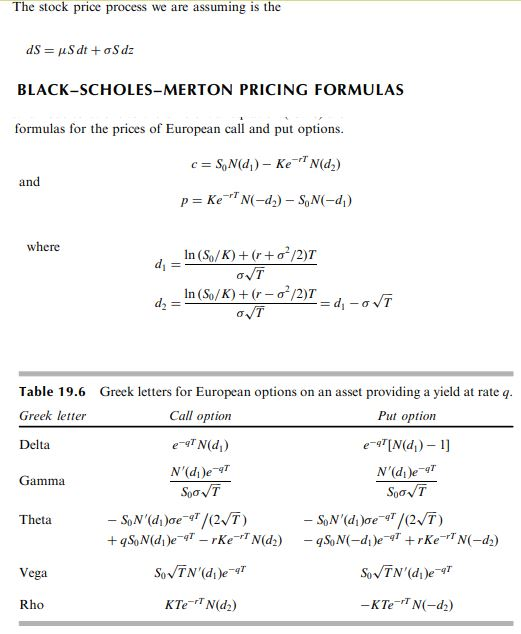



In [9]:
class BSM:
    def __init__(self,Call,S,K,V,T,R,Q,Long,N,TP):
        self.Call=Call
        self.S=S
        self.K=K
        self.V=V
        self.T=T
        self.R=R
        self.Q=Q
        self.Long=Long
        self.N=N
        self.TP=TP
        self.d1=(np.log(self.S/self.K)+(self.R-self.Q+(self.V**2)*0.5)*self.T)/(self.V*np.sqrt(self.T))
        self.d2=(np.log(self.S/self.K)+(self.R-self.Q-(self.V**2)*0.5)*self.T)/(self.V*np.sqrt(self.T))
        
        self.C=(self.S*np.exp(-self.Q*self.T)*norm.cdf(self.d1))-(self.K*np.exp(-self.R*self.T)*norm.cdf(self.d2))
        self.P=(self.K*np.exp(-self.R*self.T)*norm.cdf(-self.d2))-(self.S*np.exp(-self.Q*self.T)*norm.cdf(-self.d1))
        
        self.deltac=np.exp(-self.Q*self.T)*norm.cdf(self.d1)
        self.thetac=-(self.S*np.exp(-self.Q*self.T)*norm.pdf(self.d1)*self.V*0.5/np.sqrt(self.T))-(self.R*self.K*np.exp(-self.R*self.T)*norm.cdf(self.d2))+(self.Q*self.S*np.exp(-self.Q*self.T)*norm.cdf(self.d1))
        self.thetap=-(self.S*np.exp(-self.Q*self.T)*norm.pdf(self.d1)*self.V*0.5/np.sqrt(self.T))+(self.R*self.K*np.exp(-self.R*self.T)*norm.cdf(-self.d2))-(self.Q*self.S*np.exp(-self.Q*self.T)*norm.cdf(-self.d1))
        self.gammac=np.exp(-self.Q*self.T)*norm.pdf(self.d1)/(self.S*self.V*np.sqrt(self.T))
        self.vegac=(self.S*np.exp(-self.Q*self.T)*np.sqrt(self.T)*norm.pdf(self.d1))/100
        
    def price(self):
        if self.Call:
            return self.C
        else:
            return self.P
    
    def delta(self):
        if self.Long: 
            if self.Call:
                return self.deltac*self.N
            else:
                return (self.deltac-np.exp(-self.Q*self.T))*self.N
        else:
            if self.Call:
                return -(self.deltac)*self.N
            else:
                return -(self.deltac-np.exp(-self.Q*self.T))*self.N
        
    def gamma(self):
        if self.Long: 
            if self.Call:
                return self.gammac*self.N
            else:
                return -self.gammac*self.N
        else:
            if self.Call:
                return -(self.gammac)*self.N
            else:
                return (self.gammac)*self.N
    
    def theta(self):
        if self.Long: 
            if self.Call:
                return self.thetac*self.N/365
            else:
                return self.thetap*self.N/365
        else:
            if self.Call:
                return -(self.thetac*self.N/365)
            else:
                return -(self.thetap*self.N/365)
    
    def vega(self):
        if self.Long: 
            return self.vegac*self.N
        else:
            return -self.vegac*self.N
    
    def payoff(self):
        if self.Long:
            if self.Call:
                return np.maximum(self.S-self.K,-self.TP)
            else:
                return np.maximum(self.K-self.S,-self.TP)
        else:
            if self.Call:
                return np.minimum(self.TP,self.TP-(self.S-self.K))
            else:
                return np.minimum(self.TP,self.TP-(self.K-self.S))
    



In [10]:
Spot=11300                         #Current underlying price
TP1=900.0                          #price of option when first trade took place
TP2=1300.15                        #price of option when second trade took place
TP3=550.0
today='2020-08-28'
expiry='2021-08-29'

K1=11200.0                        #Strike of 1st option trade
K2=11100.0
K3=11600.0
V1=0.24                           #Implied Volatility of first option trade
V2=0.22
V3=0.26

today=pd.to_datetime(today,format='%Y-%m-%d')
expiry=pd.to_datetime(expiry,format='%Y-%m-%d')

TTE = ((expiry - today).days)/365.0          #Time to expiry
Dividend=0.013                               #Dividiend yield 
Interest=0.06                                # Risk free interest rate

BSM1 = BSM(True, Spot, K1, V1, TTE, Interest, Dividend, False, 2,TP1)
BSM2 = BSM(True, Spot, K2, V2, TTE, Interest, Dividend, False, 2,TP2)
BSM3 = BSM(False, Spot, K3, V3, TTE, Interest, Dividend, False, 2,TP3)

def Portfolio(n):            #function to calculate the portfolio greeks of upto 3 different option trades 
    if n == 1:
        D=BSM1.delta()
        G=BSM1.gamma()
        TH=BSM1.theta()
        VG=BSM1.vega()
        
    elif n == 2:
        D=BSM1.delta() + BSM2.delta()
        G=BSM1.gamma() + BSM2.gamma()
        TH=BSM1.theta() + BSM2.theta()
        VG=BSM1.vega()+ BSM2.vega()
        
    elif n == 3:
        D=BSM1.delta() + BSM2.delta()+BSM3.delta() #+ve means long delta & -ve means short delta
        G=BSM1.gamma() + BSM2.gamma() +BSM3.gamma() #net gamma 
        TH=BSM1.theta() + BSM2.theta() + BSM3.theta() #+ve means short theta & -ve means long theta
        VG=BSM1.vega()+ BSM2.vega() + BSM3.vega()# +ve means long vega & -ve means short vega
    return D,G,TH,VG

print Portfolio(2) # Return Portfolio Delta, Gamma, Thetha & Vega in order
print BSM1.payoff()
print BSM1.price()
print BSM2.price()

(-2.5571731503278228, -0.0005638916869165024, 8.04272062594146, -165.81838426824578)
800.0
1369.486506817234
1339.1492431744382
